# import packages

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBClassifier
import shap

# data load

In [7]:
df_survey=pd.read_excel('DataSet_Final.xlsx',sheet_name='Survey Dataset')

C:\Users\bacti\miniconda3\envs\myenv\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [8]:
df_survey.head(2)

,ID,YeshuvAvoda,ShemAvoda,SugAvoda,ShemMachlaka,SugMachlaka,EzoAvoda,TeurPeula,TeurTafkid,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelAnafSofi,SemelMishlachSofi
0,1.0,ירושלים,"למ""ס","איסוף, עיבוד ופרסום נתונים",מיקרו כלכלה,טיפול בנתוני מיקרו,סגן מנהל אגף,"כנ""ל",סגן מנהל אגף,3.0,1.0,1.0,6.0,22.0,55.0,2020-06-15,8411,2120
1,2.0,ירושלים,בית חולים הדסה עין כרם,טיפול בחולים,רדיואתרפיה,טיפול בחולי סרטן,טכנאית רדיותרפיה,"כנ""ל","כנ""ל",NaN,1.0,1.0,6.0,22.0,55.0,2022-07-01,8610,3311


In [9]:
df_survey.shape

(201, 18)

# EDA

### check how many unique values

In [11]:
df_survey.nunique()

ID                   200
YeshuvAvoda           21
ShemAvoda             82
SugAvoda              78
ShemMachlaka          61
SugMachlaka           35
EzoAvoda              84
TeurPeula             32
TeurTafkid            16
MenahelEtMi            4
MaamadAvoda            4
MakorSachar            4
TeudaGvoha             7
shnotlimud            13
Gil                   29
TarichHathala         42
SemelAnafSofi         44
SemelMishlachSofi     62
dtype: int64

In [12]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 200 non-null    float64       
 1   YeshuvAvoda        200 non-null    object        
 2   ShemAvoda          200 non-null    object        
 3   SugAvoda           175 non-null    object        
 4   ShemMachlaka       136 non-null    object        
 5   SugMachlaka        66 non-null     object        
 6   EzoAvoda           193 non-null    object        
 7   TeurPeula          64 non-null     object        
 8   TeurTafkid         28 non-null     object        
 9   MenahelEtMi        33 non-null     float64       
 10  MaamadAvoda        198 non-null    float64       
 11  MakorSachar        186 non-null    float64       
 12  TeudaGvoha         198 non-null    float64       
 13  shnotlimud         198 non-null    float64       
 14  Gil       

In [13]:
#there is null in sex column
df_survey.isnull().sum()

ID                     1
YeshuvAvoda            1
ShemAvoda              1
SugAvoda              26
ShemMachlaka          65
SugMachlaka          135
EzoAvoda               8
TeurPeula            137
TeurTafkid           173
MenahelEtMi          168
MaamadAvoda            3
MakorSachar           15
TeudaGvoha             3
shnotlimud             3
Gil                    3
TarichHathala          1
SemelAnafSofi          1
SemelMishlachSofi      1
dtype: int64

In [17]:
# when we remove the row with the NULL id there are 12 columns with nulls
df_survey[~df_survey['ID'].isnull()].isnull().sum()

ID                     0
YeshuvAvoda            0
ShemAvoda              0
SugAvoda              25
ShemMachlaka          64
SugMachlaka          134
EzoAvoda               7
TeurPeula            136
TeurTafkid           172
MenahelEtMi          168
MaamadAvoda            2
MakorSachar           14
TeudaGvoha             2
shnotlimud             2
Gil                    2
TarichHathala          0
SemelAnafSofi          0
SemelMishlachSofi      0
dtype: int64

In [18]:
df_survey[df_survey['TeudaGvoha'].isnull()]

,ID,YeshuvAvoda,ShemAvoda,SugAvoda,ShemMachlaka,SugMachlaka,EzoAvoda,TeurPeula,TeurTafkid,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelAnafSofi,SemelMishlachSofi
44,45.0,ירושלים,מסעדה,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-01,5610,XXXX
107,108.0,בת ים,מסעדה,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-01,5610,XXXX
200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.725,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [19]:
#check if there are weird data
df_survey.describe()

,ID,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala
count,200.000000,33.000000,198.000000,186.000000,198.000000,198.000000,198.000000,200
mean,100.500000,2.143182,1.409091,1.338710,4.126263,14.313131,39.454545,2017-07-10 14:38:24
min,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,22.000000,1999-06-06 00:00:00
25%,50.750000,1.725000,1.000000,1.000000,3.000000,12.000000,31.000000,2011-11-08 12:00:00
50%,100.500000,2.000000,1.000000,1.000000,4.000000,14.000000,37.000000,2022-04-01 00:00:00
75%,150.250000,3.000000,1.000000,1.000000,5.000000,16.000000,46.000000,2022-11-11 00:00:00
max,200.000000,3.000000,6.000000,4.000000,7.000000,22.000000,78.000000,2026-06-06 00:00:00
std,57.879185,0.798418,1.250104,0.711532,1.324972,2.917291,12.611149,NaN


In [21]:
#there are TarichHathala in 2026 , need to verify with the buisness if there are future date for job

# Correlation test

In [24]:
df_survey.columns

Index(['ID', 'YeshuvAvoda', 'ShemAvoda', 'SugAvoda', 'ShemMachlaka',
       'SugMachlaka', 'EzoAvoda', 'TeurPeula', 'TeurTafkid', 'MenahelEtMi',
       'MaamadAvoda', 'MakorSachar', 'TeudaGvoha', 'shnotlimud', 'Gil',
       'TarichHathala', 'SemelAnafSofi', 'SemelMishlachSofi'],
      dtype='object')

In [25]:
df_survey.SemelMishlachSofi.unique()

array([2120, 3311, 3512, 5414, 5322, 5412, 3122, 2512, 5230, 2514, 3513,
       2631, 5131, 8212, 5223, 5142, '1XXX', 2342, 2635, 4313, 2131, 8183,
       2511, 3323, 9112, 5120, 9211, 7414, 3211, 7126, 9412, 'XXXX', 9329,
       2655, 7127, 4227, 2142, 2113, 3354, 2431, 5153, 2262, 3332, 1330,
       1212, 1221, 8342, 1345, 2411, '335X', 2423, 7522, 4211, 2330, 5222,
       3334, 2412, 7413, 7412, 3312, 5419, 4413, nan], dtype=object)

In [36]:
pd.isna(df_survey.SemelMishlachSofi.unique())

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [81]:
def remove_x_and_set_to_number(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and 'X' in x.upper():
        # Convert letters to numbers for uniqueness and multiply by -1
        # Here we replace X with 0 to make it numeric
        numeric = int(x.upper().replace('X', '0'))
        if numeric==0:
            numeric=1
        return -numeric
    return int(x)

In [82]:
df_survey['SemelMishlachSofi_1']=df_survey['SemelMishlachSofi'].apply(remove_x_and_set_to_number)

In [83]:
df_survey['SemelAnafSofi_1']=df_survey['SemelAnafSofi'].apply(remove_x_and_set_to_number)

In [85]:
df_survey[['SemelMishlachSofi_1','SemelMishlachSofi']].drop_duplicates().head()

,SemelMishlachSofi_1,SemelMishlachSofi
0,2120.0,2120
1,3311.0,3311
2,3512.0,3512
3,5414.0,5414
4,5322.0,5322


In [86]:
#function change text to numbers in order to check correlation between columns
def change_text_to_numbers(df,columns):
    for col in columns:
            enc = LabelEncoder()
            df[col+'_1'] = enc.fit_transform(df[col])
            df[col+'_1']=np.where(df[col].isnull(),np.nan,df[col+'_1'] )        
    return
    

In [87]:
df_survey.head(1).T

,0
ID,1.0
YeshuvAvoda,ירושלים
ShemAvoda,"למ""ס"
SugAvoda,"איסוף, עיבוד ופרסום נתונים"
ShemMachlaka,מיקרו כלכלה
SugMachlaka,טיפול בנתוני מיקרו
EzoAvoda,סגן מנהל אגף
TeurPeula,"כנ""ל"
TeurTafkid,סגן מנהל אגף
MenahelEtMi,3.0


In [88]:
df_survey.columns

Index(['ID', 'YeshuvAvoda', 'ShemAvoda', 'SugAvoda', 'ShemMachlaka',
       'SugMachlaka', 'EzoAvoda', 'TeurPeula', 'TeurTafkid', 'MenahelEtMi',
       'MaamadAvoda', 'MakorSachar', 'TeudaGvoha', 'shnotlimud', 'Gil',
       'TarichHathala', 'SemelAnafSofi', 'SemelMishlachSofi',
       'SemelMishlachSofi_1', 'YeshuvAvoda_1', 'ShemAvoda_1', 'SugAvoda_1',
       'ShemMachlaka_1', 'SugMachlaka_1', 'EzoAvoda_1', 'TeurPeula_1',
       'SemelAnafSofi_1'],
      dtype='object')

In [89]:
change_text_to_numbers(df_survey,['YeshuvAvoda','ShemAvoda','SugAvoda','ShemMachlaka','SugMachlaka','EzoAvoda','TeurPeula'])

In [90]:
df_survey[['YeshuvAvoda','YeshuvAvoda_1']].drop_duplicates().head()

,YeshuvAvoda,YeshuvAvoda_1
0,ירושלים,10.0
2,באר שבע,3.0
3,תל אביב,20.0
5,חיפה,7.0
6,קרית גת,17.0


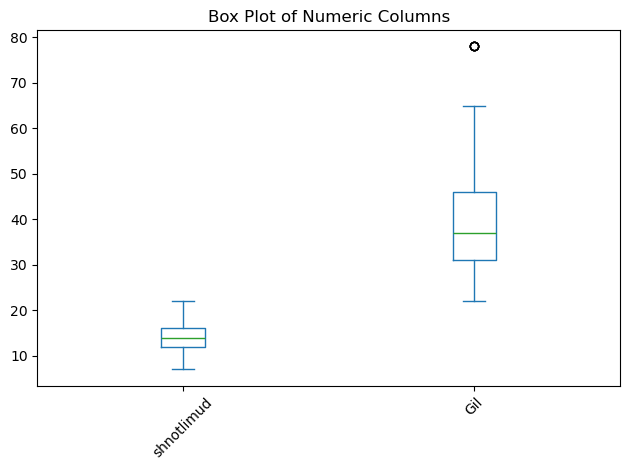

In [91]:
# check anomlies in the numeric columns
df_survey[[
 'shnotlimud','Gil']].plot.box()
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
corr_all_columns= df_survey[[col for col in df_survey.columns if df_survey[col].dtype != 'object']].corr()
corr_all_columns

,ID,MenahelEtMi,MaamadAvoda,MakorSachar,TeudaGvoha,shnotlimud,Gil,TarichHathala,SemelMishlachSofi_1,YeshuvAvoda_1,ShemAvoda_1,SugAvoda_1,ShemMachlaka_1,SugMachlaka_1,EzoAvoda_1,TeurPeula_1,SemelAnafSofi_1
ID,1.000000,-0.249673,0.009576,-0.023255,-0.172731,-0.207389,-0.099193,0.052768,0.036141,0.103402,0.043137,0.162341,0.004239,0.216258,0.016320,0.120543,-0.085065
MenahelEtMi,-0.249673,1.000000,-0.261257,-0.457662,0.414511,0.479629,0.434567,0.059137,-0.591899,-0.021147,0.194505,-0.558518,-0.084130,-0.006469,-0.076881,-0.435356,0.125836
MaamadAvoda,0.009576,-0.261257,1.000000,0.006590,-0.120218,-0.167534,0.398030,0.134439,0.358688,-0.103888,0.110575,-0.172213,-0.127691,-0.274745,-0.239572,0.060875,-0.287398
MakorSachar,-0.023255,-0.457662,0.006590,1.000000,-0.337547,-0.372826,0.076424,0.189505,0.195021,-0.112362,0.202685,-0.023247,0.074181,0.090706,-0.025802,0.221228,0.034233
TeudaGvoha,-0.172731,0.414511,-0.120218,-0.337547,1.000000,0.887982,0.270566,-0.299522,-0.668511,0.090941,-0.290825,-0.055196,-0.208999,-0.014753,-0.151583,-0.226995,0.183667
shnotlimud,-0.207389,0.479629,-0.167534,-0.372826,0.887982,1.000000,0.234946,-0.170843,-0.609411,0.027849,-0.301995,-0.107732,-0.186739,-0.030899,-0.127345,-0.264530,0.241169
Gil,-0.099193,0.434567,0.398030,0.076424,0.270566,0.234946,1.000000,-0.292601,-0.138365,-0.036609,-0.049516,-0.187362,-0.099280,-0.228354,-0.151185,0.086222,-0.209475
TarichHathala,0.052768,0.059137,0.134439,0.189505,-0.299522,-0.170843,-0.292601,1.000000,0.271128,-0.012287,0.116373,0.050247,0.306490,0.049840,0.257922,0.017687,0.089831
SemelMishlachSofi_1,0.036141,-0.591899,0.358688,0.195021,-0.668511,-0.609411,-0.138365,0.271128,1.000000,-0.052625,0.046175,-0.096655,0.162498,-0.230292,-0.101139,0.106369,-0.280323
YeshuvAvoda_1,0.103402,-0.021147,-0.103888,-0.112362,0.090941,0.027849,-0.036609,-0.012287,-0.052625,1.000000,-0.098758,0.005922,-0.040631,0.230148,-0.020008,0.019771,-0.110393


In [93]:
corr_all_columns.sort_values(['SemelMishlachSofi_1'])['SemelMishlachSofi_1']

TeudaGvoha            -0.668511
shnotlimud            -0.609411
MenahelEtMi           -0.591899
SemelAnafSofi_1       -0.280323
SugMachlaka_1         -0.230292
Gil                   -0.138365
EzoAvoda_1            -0.101139
SugAvoda_1            -0.096655
YeshuvAvoda_1         -0.052625
ID                     0.036141
ShemAvoda_1            0.046175
TeurPeula_1            0.106369
ShemMachlaka_1         0.162498
MakorSachar            0.195021
TarichHathala          0.271128
MaamadAvoda            0.358688
SemelMishlachSofi_1    1.000000
Name: SemelMishlachSofi_1, dtype: float64

In [98]:
tehuda_map={ 'yesodi':1,
            'tichon': 2, 
            'bagrut':3 ,
            'al tichoni':4,
            'BA':5,
            'MA':6,
           'PHD':7}

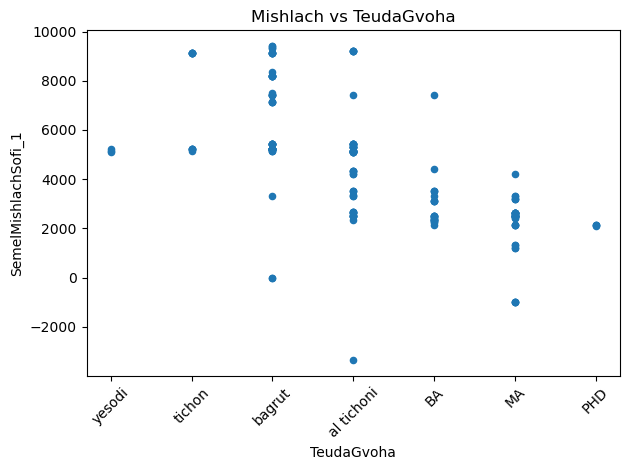

In [99]:
df_survey.plot.scatter(x='TeudaGvoha', y='SemelMishlachSofi_1', title='Mishlach vs TeudaGvoha')
plt.xticks(
    ticks=list(tehuda_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(tehuda_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)
plt.tight_layout() 
plt.show()

In [100]:
MenahelEtMi_map={'manage workers':1,
                 'manage managers':2,
                'manage both':3
}

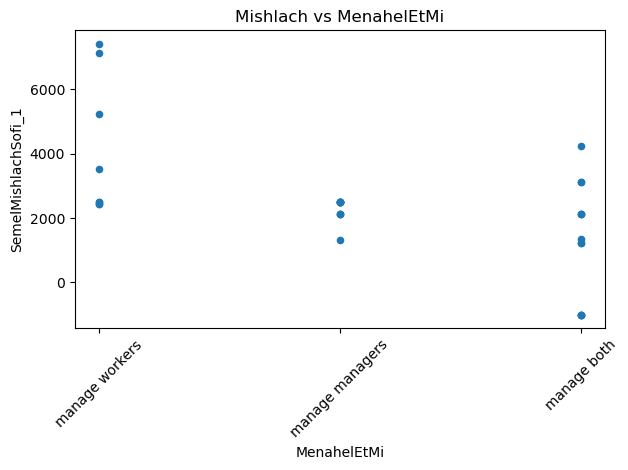

In [101]:
df_survey.plot.scatter(x='MenahelEtMi', y='SemelMishlachSofi_1', title='Mishlach vs MenahelEtMi')
plt.xticks(
    ticks=list(MenahelEtMi_map.values()),  # [0, 1, 2, 3, 4, 5]
    labels=list(MenahelEtMi_map.keys()),   # ['Coronary Heart Disease', ...]
    rotation=45                         # Optional: rotate for better readability
)
plt.tight_layout() 
plt.show()

,SemelMishlachSofi_1,count_id
0,-3350.0,1
1,-1000.0,4
2,-1.0,4
3,1212.0,1
4,1221.0,1
...,...,...
57,8342.0,1
58,9112.0,12
59,9211.0,5
60,9329.0,2


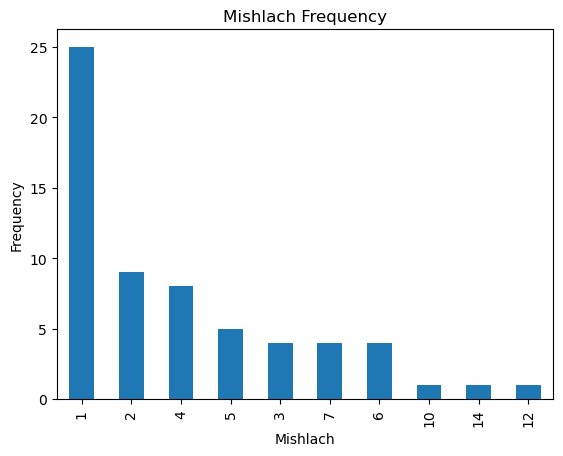

In [112]:
# by the histogram below I can see the data is divided equly except from Autoimmune Disorder
#it could lead to imbalance model in this specific disease
df_count_mishlach=df_survey.groupby('SemelMishlachSofi_1').agg(count_id=('ID','count')).reset_index()
df_count_mishlach.count_id.value_counts().plot(kind='bar', title='Mishlach Frequency')

plt.xlabel('Mishlach')
plt.ylabel('Frequency')
plt.show()

<Axes: title={'center': 'Mishlach Frequency'}, xlabel='count_id'>

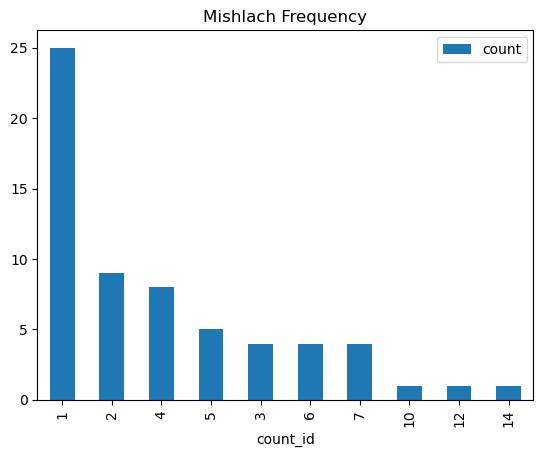

In [119]:
df_count_mishlach.count_id.value_counts().reset_index().sort_values(['count','count_id'],ascending=(False,True)).set_index('count_id').plot(kind='bar', title='Mishlach Frequency')

In [122]:
df_count_mishlach.count_id.value_counts().reset_index().sort_values(['count','count_id'],ascending=(False,True)).to_clipboard(index=False)